In [115]:
import copy
import sys
sys.path.append('/home/diego/Dropbox/hold_noise/mpl_styles/')

import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import torch
from torch.optim import Adam
# import seaborn as sns

from gglm.glm.holi import MMDGLM
from gglm.glm.torchglm import TorchGLM
# from gglm.cnncritic import MMDCritic
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from kernel.fun import KernelFun
from kernel.rect import KernelRect

import myplt

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from nips import *
for key, val in paper.items():
    mpl.rcParams[key] = val
palette = dict(d='C0', ml='C2', mmd='C1')    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = "/home/diego/python/generative-glm/cool_stuff/p110509b_dots_mat_diego.h5"
f = h5py.File(path, "r")

mask_spikes = np.array(np.stack((f['spk']), axis=1), dtype=bool)
t = np.arange(0, mask_spikes.shape[0], 1)
dt = 1

n_train = 500
mask_spikes_train = mask_spikes[:, :n_train]
mask_spikes_val = mask_spikes[:, n_train:]
fr_val = np.mean(np.sum(mask_spikes_val, 0) / (t[-1] - t[0] + t[1]) * 1000)

st_train = SpikeTrain(t, mask_spikes_train)
st_val = SpikeTrain(t, mask_spikes_val)
isi_val = st_val.isi_distribution()
mean_isi_val = np.mean(isi_val)

In [3]:
def fun_metrics_ml(model, t, mask_spikes, X):
    n_batch_fr = 200
    T = st_val.t[-1] - st_val.t[0] + st_val.t[1]
    u_dc_val, r_dc_val = model.sample_conditioned(st_val.t, st_val.mask)
    nll_val = -(np.sum(np.log(1 - np.exp(-dt * r_dc_val[mask_spikes_val]) + 1e-24) ) - \
                dt * np.sum(r_dc_val[~mask_spikes_val]))
    u_fr, r_fr, mask_spikes_fr = model.sample(st_val.t, shape=(n_batch_fr,))
#     mmd = kerneln_npsk(st_val.t, mask_spikes, mask_spikes_fr)
    fr = np.sum(mask_spikes_fr, 0) / T * 1000
    mu_fr = np.mean(fr)
    sd_fr = np.std(fr)# / np.sqrt(n_batch_fr)
    p5_fr = np.percentile(fr, 5)
    p10_fr = np.percentile(fr, 10)
    p25_fr = np.percentile(fr, 25)
    p50_fr = np.median(fr)
    p75_fr = np.percentile(fr, 75)
    p90_fr = np.percentile(fr, 90)
    p95_fr = np.percentile(fr, 95)
    return dict(nll_val=nll_val, mu_fr=mu_fr, sd_fr=sd_fr, p5_fr=p5_fr, p10_fr=p10_fr, p25_fr=p25_fr, 
                p50_fr=p50_fr, p75_fr=p75_fr, p90_fr=p90_fr, p95_fr=p95_fr)

def fun_metrics_mmd(model, t, mask_spikes, X):
#     n_batch_fr = 200
    dt = 1
    T = st_val.t[-1] - st_val.t[0] + st_val.t[1]
    theta_g = model.get_params()
    u_dc_train = torch.einsum('tka,a->tk', X, theta_g.detach())
    r_dc_train = model.non_linearity_torch(u_dc_train)
    nll_train = -(torch.sum(torch.log(1 - np.exp(-dt * r_dc_train[mask_spikes]) + 1e-24) ) - \
                dt * torch.sum(r_dc_train[~mask_spikes]))
#     u_dc_train = torch.einsum('tka,a->tk', X, theta_g)
#     r_dc_train = self.non_linearity_torch(u_dc_train)
#     nll_train = -(np.sum(np.log(1 - np.exp(-dt * r_dc_train[mask_spikes]) + 1e-24) ) - \
#                 dt * np.sum(r_dc_train[~mask_spikes]))
#     u_dc_val, r_dc_val = model.sample_conditioned(st_val.t, st_val.mask)
#     nll_val = -(np.sum(np.log(1 - np.exp(-dt * r_dc_val[mask_spikes_val]) + 1e-24) ) - \
#                 dt * np.sum(r_dc_val[~mask_spikes_val]))
    fr = 0
#     fr = np.sum(mask_spikes_fr, 0) / T * 1000
#     mu_fr = np.mean(fr)
#     sd_fr = np.std(fr)# / np.sqrt(n_batch_fr)
#     p5_fr = np.percentile(fr, 5)
#     p10_fr = np.percentile(fr, 10)
#     p25_fr = np.percentile(fr, 25)
#     p50_fr = np.median(fr)
#     p75_fr = np.percentile(fr, 75)
#     p90_fr = np.percentile(fr, 90)
#     p95_fr = np.percentile(fr, 95)
    return dict(nll_train=nll_train)
#     return dict(nll_val=nll_val, mu_fr=mu_fr, sd_fr=sd_fr, p5_fr=p5_fr, p10_fr=p10_fr, p25_fr=p25_fr, 
#                 p50_fr=p50_fr, p75_fr=p75_fr, p90_fr=p90_fr, p95_fr=p95_fr)

### ML

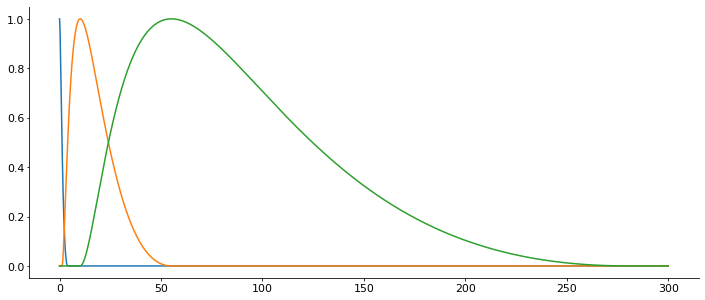

In [4]:
def raised_cosine(t, phi, a, c):
    return (1 + np.cos(np.maximum(-np.pi, np.minimum(a * np.log(t + c) - phi, np.pi)))) / 2

phi = np.array([0, np.pi * 1.5, 2.5 * np.pi])
a, c = 1.95e0, 1e0

_t = np.arange(0, 300, .1)
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(_t, raised_cosine(_t[:, None], phi[None, :], a, c))

In [5]:
tbins = [0, 4, 8, 16, 32, 64, 96, 128, ]
tbins = np.arange(0, 350, 25)
eta0 = KernelRect(tbins=tbins, coefs=np.zeros(len(tbins) - 1))
# eta.coefs = np.array([-1.6,  0.7,  0.8,  0.5, -0.1, -0.3 , -0.7, -1])
eta0 = KernelFun(raised_cosine, basis_kwargs=dict(phi=phi), 
                     shared_kwargs=dict(a=a, c=c), coefs=np.array([-3., 0.2, 0]), support=[0, 300])

lr = 1e-1
num_epochs = 400

glm = TorchGLM(u0=-5, eta=eta0.copy())
# glm.metrics = fun_metrics_ml
optim = Adam(glm.parameters(), lr=lr)
loss_ml, metrics_ml = glm.train(st_train.t, st_train.mask, optim=optim, num_epochs=num_epochs, verbose=True, metrics=fun_metrics_ml)
iterations_ml = np.arange(1, num_epochs + 1, 1)

_, r_val_dc_ml = glm.sample_conditioned(st_val.t, st_val.mask)
r_val_dc_ml = np.mean(r_val_dc_ml, 1)
_, r_fr_ml, mask_spikes_fr_ml = glm.sample(st_val.t, shape=(st_val.mask.shape[1],))
# st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml[:, np.random.choice(n_batch_fr, size=)])
st_fr_ml = SpikeTrain(st_val.t, mask_spikes_fr_ml)
mean_r_fr_ml = np.mean(r_fr_ml, 1)
sum_r_fr_ml = np.sum(r_fr_ml, 1)

 epoch 399 of 400 nll 15406.29

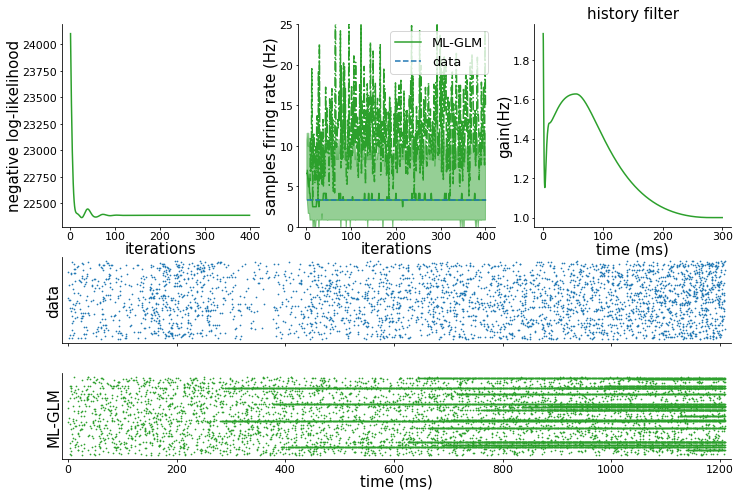

In [6]:
for key, val in metrics_ml.items():
    metrics_ml[key] = np.array(val)

r1 = 2
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((4, 3), (0, 0), rowspan=r1)
ax2 = plt.subplot2grid((4, 3), (0, 1), rowspan=r1)
ax3 = plt.subplot2grid((4, 3), (0, 2), rowspan=r1)
ax4 = plt.subplot2grid((4, 3), (2, 0), colspan=3)
ax5 = plt.subplot2grid((4, 3), (3, 0), colspan=3, sharex=ax4)

# ax1.plot(iterations_ml, loss_ml, color=palette['ml'])
ax1.plot(iterations_ml, metrics_ml['nll_val'], color=palette['ml'])
myplt.set_labels(ax1, xlabel='iterations', ylabel='negative log-likelihood')

ax2.plot(iterations_ml, metrics_ml['mu_fr'], '-.', color=palette['ml'])
# ax2.fill_between(iterations_ml, metrics_ml['mu_fr'] - metrics_ml['sd_fr'], metrics_ml['mu_fr'] + metrics_ml['sd_fr'], alpha=0.5)
ax2.plot(iterations_ml, metrics_ml['p50_fr'], color=palette['ml'], label='ML-GLM')
# ax2.fill_between(iterations_ml, metrics_ml['p10_fr'], metrics_ml['p90_fr'], alpha=0.5, color=palette['ml'])
ax2.fill_between(iterations_ml, metrics_ml['p5_fr'], metrics_ml['p95_fr'], alpha=0.5, color=palette['ml'])
# ax2.plot(iterations_ml, metrics_ml['p50_fr'], color=palette['ml'])
ax2.plot([1, num_epochs + 1], [fr_val, fr_val], '--', color=palette['d'], label='data')
ax2.set_ylim(0, 25)
myplt.set_labels(ax2, xlabel='iterations', ylabel='samples firing rate (Hz)')
ax2.legend()

glm.eta.plot(ax=ax3, exp_values=True, color=palette['ml'])
myplt.set_labels(ax3, xlabel='time (ms)', ylabel='gain(Hz)', title='history filter')

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=3)
# st_train.plot(ax=ax1, ms=0.7, color=palette['d'])
st_val.plot(ax=ax4, ms=0.7, color=palette['d'])
ax4.tick_params(axis='both', labelbottom=False, labelleft=False)
ax4.set_yticks([])
# ax4.set_xlabel(None)
ax4.set_ylabel('data')

st_fr_ml.plot(ax=ax5, ms=0.7, color=palette['ml'])
myplt.set_labels(ax5, xlabel='time (ms)', ylabel='ML-GLM')
ax5.set_yticks([])

fig.subplots_adjust(hspace=0.35)
fig.savefig('/home/diego/Dropbox/generative_glm/figures/diverging_fr_ml.pdf', transparent=True)

### MMD

In [17]:
from torch.optim import Adagrad, RMSprop, SGD
from torch.optim.lr_scheduler import ExponentialLR

In [28]:
def fun_metrics_mmd(model, t, mask_spikes, mask_spikes_fr):
    dt = 1
#     T = st_val.t[-1] - st_val.t[0] + st_val.t[1]
    T_train = t[-1] - t[0] + t[1]
#     theta_g = model.get_params()
#     u_dc_val, r_dc_val = model.sample_conditioned(st_val.t, st_val.mask)
#     u_dc_val = torch.einsum('tka,a->tk', X, theta_g.detach())
#     r_dc_train = model.non_linearity_torch(u_dc_train)
    fr_fr = torch.mean(torch.sum(mask_spikes_fr.double(), 0)) / T_train * 1000
#     nll_val = -(np.sum(np.log(1 - np.exp(-dt * r_dc_val[st_val.mask]) + 1e-24) ) - \
#                  dt * np.sum(r_dc_val[~st_val.mask]))
    return dict(fr_fr=fr_fr)
#     return dict(nll_val=nll_val, fr_fr=fr_fr)

In [107]:
def kerneln_expn(t, mask_spikes1, mask_spikes2):
    n_spk1 = torch.sum(mask_spikes1, 0).double()
    n_spk2 = torch.sum(mask_spikes2, 0).double()
#     gramian = n_spk1[:, None] * n_spk2[None, :]
    gramian = torch.exp(-(n_spk1[:, None] - n_spk2[None, :])**2 / sd2)
#     gramian = torch.from_numpy(gramian)
    return gramian
phi, kernel = None, kerneln_npsk

def phi_sum(t, mask_spikes):
    return torch.sum(mask_spikes, 0).double()[None, :]

dic_ker_strings = {'phi_id': "<r,r'>", 'phi_mean': "mu_r * mu_r'", 'phi_sum': "sum_s * sum_s'", 
                   'kerneln_expn': "exp(-sum((s-s')^2)/sd^2)"}
dic_ker_name = {'phi_id': "canonical_dot", 'phi_mean': 'means_product', 'phi_sum': "sum_product", 
               'kerneln_expn': "gaussian"}

In [112]:
# phi, kernel, lam_mmd, lr, clip = phi_sum, None, 1e0, 1e-6, 1e0
phi, kernel, lam_mmd, lr, clip = None, kerneln_expn, 1e3, 1e-2, 1e0

n_batch_fr = 200
num_epochs = 800
biased = False
sd2 = 1e1

import time
time0 = time.time()

# lr = 5e-2 # exponential kernel
# gamma = 0.996

# eta0_scaled = glm.eta.copy()
# eta0_scaled.coefs = eta0_scaled.coefs * 0.5
# mmdglm_nspk2 = MMDGLM(u0=glm.u0, eta=eta0_scaled.copy())

mmdglm = MMDGLM(u0=glm.u0, eta=glm.eta.copy())
optim = Adam(mmdglm.parameters(), lr=lr, betas=(0, 0.999))
# scheduler = ExponentialLR(optim, gamma)

loss_mmd, nll_train, metrics_mmd = mmdglm.train(st_train.t, torch.from_numpy(mask_spikes_train), phi=phi, kernel=kernel, 
                                              log_likelihood=True, n_batch_fr=n_batch_fr, lam_mmd=lam_mmd, clip=clip, biased=biased,
                                              optim=optim, scheduler=None, num_epochs=num_epochs, verbose=True, 
                                              metrics=fun_metrics_mmd, n_metrics=1)
loss_mmd, nll_train = np.array(loss_mmd), np.array(nll_train)
metrics_mmd['mmd'] = np.array(metrics_mmd['mmd'])
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_dc_mmd = mmdglm.sample_conditioned(st_val.t, st_val.mask)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(st_val.mask.shape[1],))
st_fr_mmd = SpikeTrain(st_val.t, mask_spikes_fr_mmd)
isi_fr_mmd = st_fr_mmd.isi_distribution()
mean_isi_fr_mmd = np.mean(isi_fr_mmd)
r_dc_mmd, r_fr_mmd = r_dc_mmd * 1000, r_fr_mmd * 1000

time1 = time.time()
print('\n', 'took', time1 - time0, 'seconds', (time1 - time0) / 60, 'minutes')

 epoch 799 of 800 loss 14052.0859375
 took 450.36282539367676 seconds 7.506047089894612 minutes


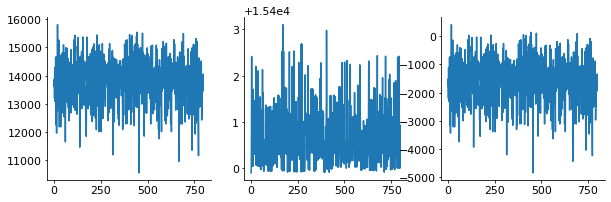

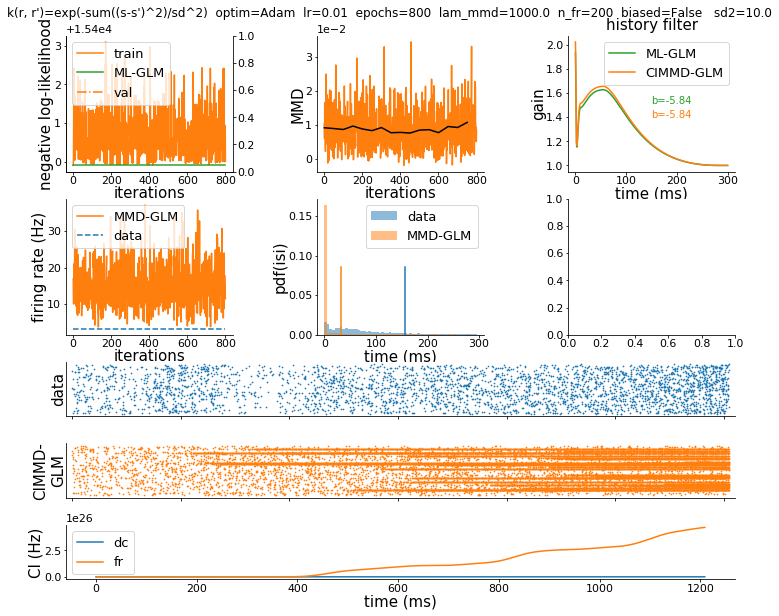

In [114]:
for key, val in metrics_mmd.items():
    metrics_mmd[key] = np.array(val)

if phi is not None:
    ker_name = phi.__name__
else:
    ker_name = kernel.__name__
    
title = "k(r, r')=" + dic_ker_strings[ker_name] + '  optim=' + str(optim.__class__.__name__) + '  lr=' + str(lr) \
     + '  epochs=' + str(num_epochs) + \
       '  lam_mmd=' + str(lam_mmd) + '  n_fr=' + str(n_batch_fr) + '  biased=' + str(biased) + '   sd2=' + str(sd2)
    
r1, r2 = 2, 1
ncols = 3

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 3), ncols=3)
ax1.plot(loss_mmd)
ax2.plot(nll_train)
ax3.plot(loss_mmd - nll_train)

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
fig = plt.figure(figsize=(12, 10))
fig.suptitle(title, fontsize=12, y=0.92)
ax00 = plt.subplot2grid((2*r1 + 3*r2, ncols), (0, 0), rowspan=r1)
ax01 = plt.subplot2grid((2*r1 + 3*r2, ncols), (0, 1), rowspan=r1)
ax02 = plt.subplot2grid((2*r1 + 3*r2, ncols), (0, 2), rowspan=r1)
ax10 = plt.subplot2grid((2*r1 + 3*r2, ncols), (r1, 0), rowspan=r1)
ax11 = plt.subplot2grid((2*r1 + 3*r2, ncols), (r1, 1), rowspan=r1)
ax12 = plt.subplot2grid((2*r1 + 3*r2, ncols), (r1, 2), rowspan=r1)
ax2 = plt.subplot2grid((2*r1 + 3*r2, ncols), (2*r1, 0), colspan=ncols)
ax3 = plt.subplot2grid((2*r1 + 3*r2, ncols), (2*r1 + r2, 0), colspan=ncols)
ax4 = plt.subplot2grid((2*r1 + 3*r2, ncols), (2*r1 + 2*r2, 0), colspan=ncols)

ax00.plot(iterations_mmd, nll_train, '-', label='train', color=palette['mmd'])
ax00.plot([iterations_mmd[0], iterations_mmd[-1]], [nll_train[0], nll_train[0]], '-', label='ML-GLM', color=palette['ml'])
ax00.spines['right'].set_visible(True)
ax00.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax00.plot(iterations_mmd[0], nll_train[0], '-.', label='val', color=palette['mmd'])
ax00.legend()
ax00twin = ax00.twinx()
# ax00twin.plot(iterations_mmd, metrics_mmd['nll_val'], '-.', label='val', color=palette['mmd'])
myplt.set_labels(ax00, xlabel='iterations', ylabel='negative log-likelihood')
ax00twin.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

ax01.plot(iterations_mmd, metrics_mmd['mmd'], label='CIMMD-GLM', color=palette['mmd'])
# ax01.set_ylim(-1e-1, np.median(metrics_mmd['mmd'][-10:]) * 5)
ss = 50
_aux = [np.mean(metrics_mmd['mmd'][ii * ss:(ii + 1) * ss]) for ii in range(num_epochs // ss)]
ax01.plot(iterations_mmd[::ss], _aux, 'k-')
ax01.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
myplt.set_labels(ax01, xlabel='iterations', ylabel='MMD')

glm.eta.plot(ax=ax02, exp_values=True, label='ML-GLM', color=palette['ml'])
mmdglm.eta.plot(ax=ax02, exp_values=True, label='CIMMD-GLM', color=palette['mmd'])
myplt.set_labels(ax02, xlabel='time (ms)', ylabel='gain', title='history filter')
ax02.text(0.5, 0.5, 'b=' + str(np.round(glm.u0, 2)), color=palette['ml'], transform=ax02.transAxes)
ax02.text(0.5, 0.4, 'b=' + str(np.round(mmdglm.u0, 2)), color=palette['mmd'], transform=ax02.transAxes)
ax02.legend()

ax10.plot(iterations_mmd, metrics_mmd['fr_fr'], label='MMD-GLM', color=palette['mmd'])
ax10.plot([iterations_mmd[0], iterations_mmd[-1]], [fr_val, fr_val], '--', label='data', color=palette['d'])
myplt.set_labels(ax10, xlabel='iterations', ylabel='firing rate (Hz)')
ax10.legend()

bins = np.arange(0, 300, 5)
ax11.hist(isi_val, density=True, alpha=0.5, color=palette['d'], label='data', bins=bins)
ax11.hist(isi_fr_mmd, density=True, alpha=0.5, color=palette['mmd'], label='MMD-GLM', bins=bins)
ax11.legend()
y1 = ax11.get_ylim()[1] / 2
ax11.plot([mean_isi_val, mean_isi_val], [0, y1], '-', color=palette['d'])
ax11.plot([mean_isi_fr_mmd, mean_isi_fr_mmd], [0, y1], '-', color=palette['mmd'])
myplt.set_labels(ax11, xlabel='time (ms)', ylabel='pdf(isi)')

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=3)
# st_train.plot(ax=ax1, ms=0.7, color=palette['d'])
st_val.plot(ax=ax2, ms=0.7, color=palette['d'])
ax2.tick_params(axis='both', labelbottom=False, labelleft=False)
ax2.set_yticks([])
ax2.set_ylabel('data')

st_fr_mmd.plot(ax=ax3, ms=0.7, color=palette['mmd'])
ax3.tick_params(axis='both', labelbottom=False, labelleft=False)
ax3.set_yticks([])
ax3.set_ylabel('CIMMD-\nGLM')

ax4.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='dc')
ax4.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='fr')
ax4.legend()
myplt.set_labels(ax4, xlabel='time (ms)', ylabel='CI (Hz)')

fig.subplots_adjust(hspace=0.5, wspace=0.5)
# fig.tight_layout()

fig_name = dic_ker_name[ker_name] + '_' + 'lammmd' + str(lam_mmd) + '_epochs' + str(num_epochs) + '_' + 'lr' + str(lr)

import os
list_files = os.listdir('/home/diego/Dropbox/generative_glm/figures/huk_mmd/')

ii = 1
while fig_name + '_' + str(ii) + '.pdf' in list_files:
    ii += 1
fig_name += '_' + str(ii) + '.pdf'

fig.savefig('/home/diego/Dropbox/generative_glm/figures/huk_mmd/' + fig_name, transparent=True)

KeyError: 'nll_train'

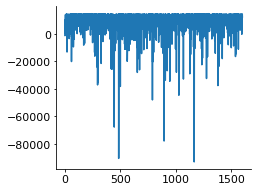

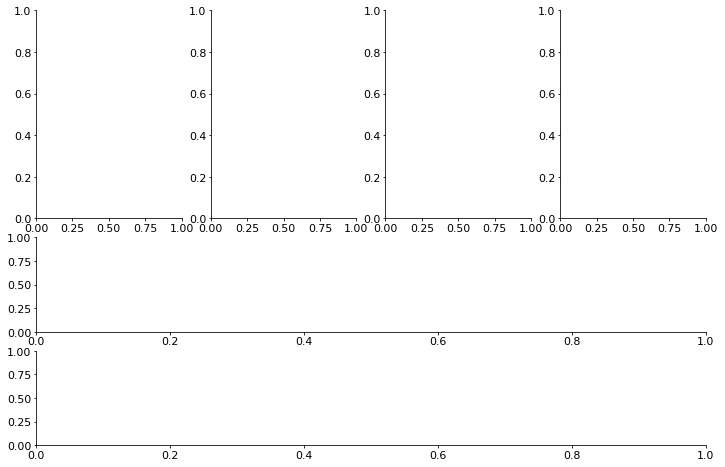

In [72]:
for key, val in metrics_mmd.items():
    metrics_mmd[key] = np.array(val)

r1 = 2

fig, ax = plt.subplots()
ax.plot(loss_mmd)

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=r1)
ax6 = plt.subplot2grid((4, 4), (0, 1), rowspan=r1)
ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=r1)
ax3 = plt.subplot2grid((4, 4), (0, 3), rowspan=r1)
ax4 = plt.subplot2grid((4, 4), (2, 0), colspan=4)
ax5 = plt.subplot2grid((4, 4), (3, 0), colspan=4, sharex=ax4)

ax1.plot(iterations_mmd, metrics_mmd['nll_train'], '-', color=palette['mmd'])
# ax1.plot(iterations_mmd, metrics_mmd['nll_val'], '--', color=palette['mmd'])
myplt.set_labels(ax1, xlabel='iterations', ylabel='negative log-likelihood')

# ax2.plot(iterations_mmd, metrics_mmd['mu_fr'], '-.', color=palette['mmd'])
# ax2.plot(iterations_mmd, metrics_mmd['p50_fr'], color=palette['mmd'], label='MMD-GLM')
# ax2.fill_between(iterations_mmd, metrics_mmd['p5_fr'], metrics_mmd['p95_fr'], alpha=0.5, color=palette['mmd'])
# ax2.plot([1, iterations_mmd[-1]], [fr_val, fr_val], '--', color=palette['d'], label='data')
# # ax2.set_ylim(0, 25)
# myplt.set_labels(ax2, xlabel='iterations', ylabel='samples firing rate (Hz)')
# ax2.legend()

ss = 100
_aux = [np.mean(mmd_mmd[ii * ss:(ii + 1) * ss]) for ii in range(num_epochs // ss)]
ax6.plot(iterations_mmd, mmd_mmd, label='MMD-GLM', color=palette['mmd'])
ax2.plot(iterations_mmd[::ss], _aux, 'k-')
myplt.set_labels(ax6, xlabel='iterations', ylabel='MMD')
ax2.set_ylim(0, 5e-3)

glm.eta.plot(ax=ax3, exp_values=True, color=palette['ml'])
mmdglm_nspk2.eta.plot(ax=ax3, exp_values=True, color=palette['mmd'])
myplt.set_labels(ax3, xlabel='time (ms)', ylabel='gain(Hz)', title='history filter')

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=3)
# st_train.plot(ax=ax1, ms=0.7, color=palette['d'])
st_val.plot(ax=ax4, ms=0.7, color=palette['d'])
ax4.tick_params(axis='both', labelbottom=False, labelleft=False)
ax4.set_yticks([])
# ax4.set_xlabel(None)
ax4.set_ylabel('data')

st_fr_mmd.plot(ax=ax5, ms=0.7, color=palette['mmd'])
myplt.set_labels(ax5, xlabel='time (ms)', ylabel='MMD-GLM')
ax5.set_yticks([])

# fig.subplots_adjust(hspace=0.35)
fig.tight_layout()
fig.savefig('/home/diego/Dropbox/generative_glm/figures/diverging_fr_frkernel24_mmd.pdf', transparent=True)

In [67]:
lam_mmd = 1e0
lr = 2e-2
num_epochs = 100

mmdglm = MMDGLM(u0=-5, eta=eta0.copy())
optim = Adam(mmdglm.parameters(), lr=lr, betas=(0, 0.999))
# optim = SGD(mmdglm.parameters(), lr=2e-2)
# optom = Adagrad(mmdglm.parameters(), lr=lr)
loss_mmd, mmd_mmd, metrics_mmd = mmdglm.train(st_train.t, torch.from_numpy(mask_spikes_train), phi=None, kernel=kerneln_npsk, 
                                   optim=optim, num_epochs=num_epochs, verbose=True, metrics=fun_metrics_ml)
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_fr_ml, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(st_val.mask.shape[1],))
st_fr_mmd = SpikeTrain(st_val.t, mask_spikes_fr_mmd)
mask_spikes_fr_mmd_nspk = mask_spikes_fr_mmd.copy()

 epoch 4 of 100 loss -2088.9368997689

KeyboardInterrupt: 

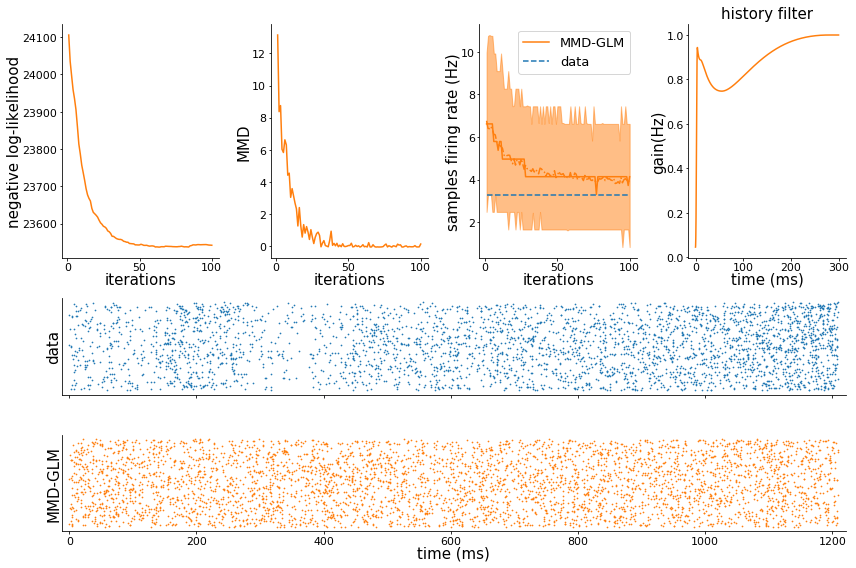

In [53]:
for key, val in metrics_mmd.items():
    metrics_mmd[key] = np.array(val)

r1 = 2
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=r1)
ax6 = plt.subplot2grid((4, 4), (0, 1), rowspan=r1)
ax2 = plt.subplot2grid((4, 4), (0, 2), rowspan=r1)
ax3 = plt.subplot2grid((4, 4), (0, 3), rowspan=r1)
ax4 = plt.subplot2grid((4, 4), (2, 0), colspan=4)
ax5 = plt.subplot2grid((4, 4), (3, 0), colspan=4, sharex=ax4)

ax1.plot(iterations_mmd, metrics_mmd['nll_val'], color=palette['mmd'])
myplt.set_labels(ax1, xlabel='iterations', ylabel='negative log-likelihood')

ax2.plot(iterations_mmd, metrics_mmd['mu_fr'], '-.', color=palette['mmd'])
ax2.plot(iterations_mmd, metrics_mmd['p50_fr'], color=palette['mmd'], label='MMD-GLM')
ax2.fill_between(iterations_mmd, metrics_mmd['p5_fr'], metrics_mmd['p95_fr'], alpha=0.5, color=palette['mmd'])
ax2.plot([1, iterations_mmd[-1]], [fr_val, fr_val], '--', color=palette['d'], label='data')
# ax2.set_ylim(0, 25)
myplt.set_labels(ax2, xlabel='iterations', ylabel='samples firing rate (Hz)')
ax2.legend()

ax6.plot(iterations_mmd, mmd_mmd, label='MMD-GLM', color=palette['mmd'])
myplt.set_labels(ax6, xlabel='iterations', ylabel='MMD')

mmdglm.eta.plot(ax=ax3, exp_values=True, color=palette['mmd'])
myplt.set_labels(ax3, xlabel='time (ms)', ylabel='gain(Hz)', title='history filter')

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=3)
# st_train.plot(ax=ax1, ms=0.7, color=palette['d'])
st_val.plot(ax=ax4, ms=0.7, color=palette['d'])
ax4.tick_params(axis='both', labelbottom=False, labelleft=False)
ax4.set_yticks([])
# ax4.set_xlabel(None)
ax4.set_ylabel('data')

st_fr_mmd.plot(ax=ax5, ms=0.7, color=palette['mmd'])
myplt.set_labels(ax5, xlabel='time (ms)', ylabel='MMD-GLM')
ax5.set_yticks([])

# fig.subplots_adjust(hspace=0.35)
fig.tight_layout()
fig.savefig('/home/diego/Dropbox/generative_glm/figures/diverging_fr_frkernel_mmd.pdf', transparent=True)

### MMD matching mean CI

In [32]:
lam_mmd = 1e0 # isi_mean
def kernel_ci(t, r1, r2):
#     phi1 = torch.mean(torch.from_numpy(r_dc1), 0)
#     phi2 = torch.mean(torch.from_numpy(r_dc2), 0)
#     gramian = phi1[:, None] * phi2[None, :]
    gramian = torch.sum(r1[:, :, None] * r2[:, None, :], 0)
    return gramian
phi, kernel = None, kernel_ci

In [54]:
lam_mmd = 1e4
lr = 1e-3
num_epochs = 150

mmdglm = MMDGLM(u0=-5, eta=eta0.copy())
optim = Adam(mmdglm.parameters(), lr=lr)
loss_mmd, mmd_mmd, metrics_mmd = mmdglm.train(st_train.t, torch.from_numpy(mask_spikes_train), phi=None, kernel=kernel_ci, 
                                   optim=optim, lam_mmd=lam_mmd, use_ci=True, num_epochs=num_epochs, verbose=True, metrics=fun_metrics_ml)
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_dc_mmd = mmdglm.sample_conditioned(st_val.t, st_val.mask)
_, r_fr_mmd, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(st_val.mask.shape[1],))
st_fr_mmd = SpikeTrain(st_val.t, mask_spikes_fr_mmd)
mask_spikes_fr_mmd_ci = mask_spikes_fr_mmd.copy()

 epoch 149 of 150 loss 0.0049687381

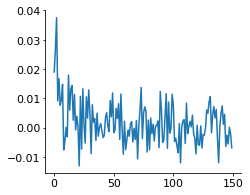

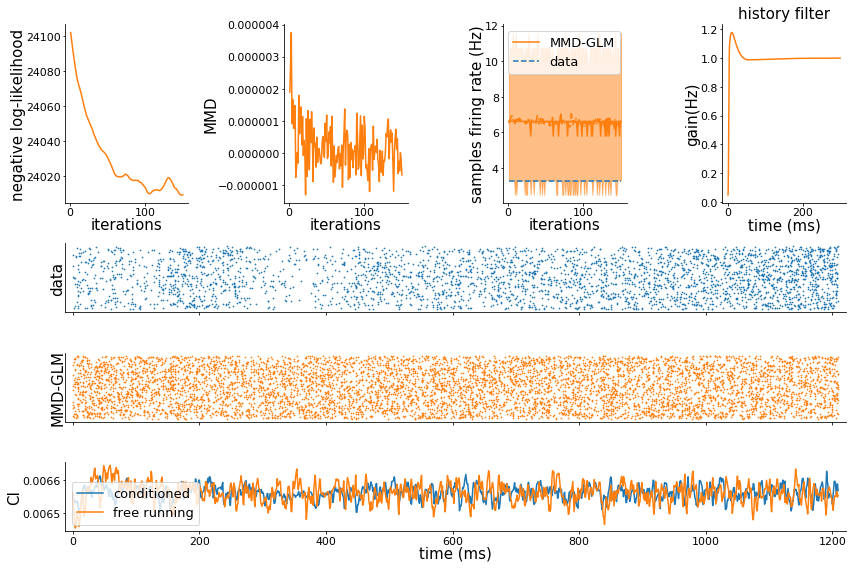

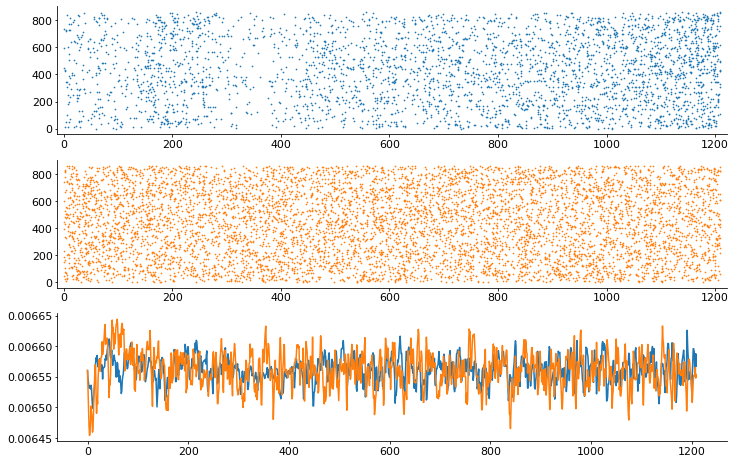

In [48]:
for key, val in metrics_mmd.items():
    metrics_mmd[key] = np.array(val)

r1 = 2
# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)

fig, ax = plt.subplots()
ax.plot(loss_mmd)

fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((r1 + 3, 4), (0, 0), rowspan=r1)
ax6 = plt.subplot2grid((r1 + 3, 4), (0, 1), rowspan=r1)
ax2 = plt.subplot2grid((r1 + 3, 4), (0, 2), rowspan=r1)
ax3 = plt.subplot2grid((r1 + 3, 4), (0, 3), rowspan=r1)
ax4 = plt.subplot2grid((r1 + 3, 4), (2, 0), colspan=4)
ax5 = plt.subplot2grid((r1 + 3, 4), (3, 0), colspan=4, sharex=ax4)
ax7 = plt.subplot2grid((r1 + 3, 4), (4, 0), colspan=4, sharex=ax4)

ax1.plot(iterations_mmd, metrics_mmd['nll_val'], color=palette['mmd'])
myplt.set_labels(ax1, xlabel='iterations', ylabel='negative log-likelihood')

ax2.plot(iterations_mmd, metrics_mmd['mu_fr'], '-.', color=palette['mmd'])
ax2.plot(iterations_mmd, metrics_mmd['p50_fr'], color=palette['mmd'], label='MMD-GLM')
ax2.fill_between(iterations_mmd, metrics_mmd['p5_fr'], metrics_mmd['p95_fr'], alpha=0.5, color=palette['mmd'])
ax2.plot([1, iterations_mmd[-1]], [fr_val, fr_val], '--', color=palette['d'], label='data')
# ax2.set_ylim(0, 25)
myplt.set_labels(ax2, xlabel='iterations', ylabel='samples firing rate (Hz)')
ax2.legend()

ax6.plot(iterations_mmd, mmd_mmd, label='MMD-GLM', color=palette['mmd'])
myplt.set_labels(ax6, xlabel='iterations', ylabel='MMD')

mmdglm.eta.plot(ax=ax3, exp_values=True, color=palette['mmd'])
myplt.set_labels(ax3, xlabel='time (ms)', ylabel='gain(Hz)', title='history filter')

# fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), nrows=3)
# st_train.plot(ax=ax1, ms=0.7, color=palette['d'])
st_val.plot(ax=ax4, ms=0.7, color=palette['d'])
ax4.tick_params(axis='both', labelbottom=False, labelleft=False)
ax4.set_yticks([])
# ax4.set_xlabel(None)
ax4.set_ylabel('data')

st_fr_mmd.plot(ax=ax5, ms=0.7, color=palette['mmd'])
myplt.set_labels(ax5, ylabel='MMD-GLM')
ax5.set_yticks([])
ax5.tick_params(axis='both', labelbottom=False, labelleft=False)
ax7.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'], label='conditioned')
ax7.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'], label='free running')
myplt.set_labels(ax7, xlabel='time (ms)', ylabel='CI')
ax7.legend()

# fig.subplots_adjust(hspace=0.35)
fig.tight_layout()
fig.savefig('/home/diego/Dropbox/generative_glm/figures/diverging_fr_mucikernel_mmd.pdf', transparent=True)

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 8), nrows=3)
st_val.plot(ax=ax1, ms=0.7, color=palette['d'])
st_fr_mmd.plot(ax=ax2, ms=0.7, color=palette['mmd'])
ax3.plot(t, np.mean(r_dc_mmd, 1), color=palette['d'])
ax3.plot(t, np.mean(r_fr_mmd, 1), color=palette['mmd'])

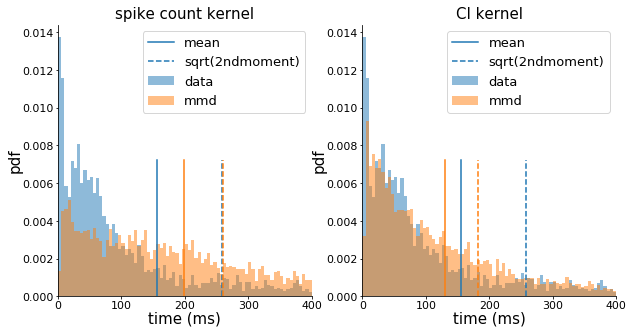

In [75]:
st_fr_mmd_nspk = SpikeTrain(st_val.t, mask_spikes_fr_mmd_nspk)
st_fr_mmd_ci = SpikeTrain(st_val.t, mask_spikes_fr_mmd_ci)
isi_val = st_val.isi_distribution()
isi_nspk = st_fr_mmd_nspk.isi_distribution()
isi_ci = st_fr_mmd_ci.isi_distribution()

mean_val = np.mean(isi_val)
mean_nspk = np.mean(isi_nspk)
mean_ci = np.mean(isi_ci)

mean2_val = np.mean(isi_val**2)**0.5
mean2_nspk = np.mean(isi_nspk**2)**0.5
mean2_ci = np.mean(isi_ci**2)**0.5

bins = np.arange(0, 1000, 5)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)
ax1.hist(isi_val, label='data', density=True, color=palette['d'], alpha=0.5, bins=bins)
ax1.hist(isi_nspk, label='mmd', density=True, color=palette['mmd'], alpha=0.5, bins=bins)
y1 = ax1.get_ylim()[1] / 2
ax1.plot([mean_val, mean_val], [0, y1], '-', label='mean', color=palette['d'])
ax1.plot([mean_nspk, mean_nspk], [0, y1], '-', color=palette['mmd'])
ax1.plot([mean2_val, mean2_val], [0, y1], '--', label='sqrt(2ndmoment)', color=palette['d'])
ax1.plot([mean2_nspk, mean2_nspk], [0, y1], '--', color=palette['mmd'])
ax1.set_xlim(0, 400)
ax1.legend()
myplt.set_labels(ax1, xlabel='time (ms)', ylabel='pdf', title='spike count kernel')

ax2.hist(isi_val, label='data', density=True, color=palette['d'], alpha=0.5, bins=bins)
ax2.hist(isi_ci, label='mmd', density=True, color=palette['mmd'], alpha=0.5, bins=bins)
y2 = ax2.get_ylim()[1] / 2
ax2.plot([mean_val, mean_val], [0, y1], '-', label='mean', color=palette['d'])
ax2.plot([mean_ci, mean_ci], [0, y1], '-', color=palette['mmd'])
ax2.plot([mean2_val, mean2_val], [0, y1], '--', label='sqrt(2ndmoment)', color=palette['d'])
ax2.plot([mean2_ci, mean2_ci], [0, y1], '--', color=palette['mmd'])
# ax2.set_title('CI kernel')
ax2.set_xlim(0, 400)
ax2.legend()
myplt.set_labels(ax2, xlabel='time (ms)', ylabel='pdf', title='CI kernel')

fig.savefig('/home/diego/Dropbox/generative_glm/figures/isis_mmd.pdf', transparent=True)

In [55]:
b(2)

NameError: name 'b' is not defined

In [ ]:
st_fr_mmd_nspk = SpikeTrain(st_val.t, mask_spikes_fr_mmd_nspk)
st_val.isi_distribution

### MMD matching mean ISI

In [62]:
lam_mmd = 1e0 # isi_mean
def kernel_meanisi(t, mask_spikes1, mask_spikes2):
    isi1 = SpikeTrain(t, mask_spikes1.numpy()).isi_distribution(concatenate=False)
    isi2 = SpikeTrain(t, mask_spikes2.numpy()).isi_distribution(concatenate=False)
    print(isi1)
    print(knwkw)
    isi1 = np.array([np.mean(_isi) for _isi in isi1 if len(_isi) > 0 else ])
    isi2 = np.array([np.mean(_isi) for _isi in isi2])
    print(isi1)
    gramian = isi1[:, None] * isi2[None, :]
    gramian = torch.from_numpy(gramian)
    return gramian
phi, kernel = None, kernel_meanisi

In [63]:
lam_mmd = 1e0
lr = 0
num_epochs = 75

mmdglm = MMDGLM(u0=-5, eta=eta0.copy())
optim = Adam(mmdglm.parameters(), lr=lr)
loss_mmd, mmd_mmd, metrics_mmd = mmdglm.train(st_train.t, torch.from_numpy(mask_spikes_train), phi=None, kernel=kernel_meanisi, 
                                   optim=optim, num_epochs=num_epochs, verbose=True, metrics=fun_metrics_ml)
iterations_mmd = np.arange(1, num_epochs + 1, 1)

_, r_fr_ml, mask_spikes_fr_mmd = mmdglm.sample(st_val.t, shape=(st_val.mask.shape[1],))
st_fr_mmd = SpikeTrain(st_val.t, mask_spikes_fr_mmd)

[array([128, 735,  23,  51,  14]), array([ 37,  65, 381, 107,  34, 153,  39, 137,  74,  18]), array([], dtype=float64), array([ 74,  38,  29,  96, 469,  23,  99]), array([731,  73,  57, 127]), array([113,  35,   7,  47,   7,  65,  47,  23,  42, 174,   8]), array([], dtype=float64), array([ 33,   3,   3, 727, 149,  45,   7]), array([  5,  33,   4, 172, 771]), array([183, 756,  27,  59,  58,  47]), array([595, 171,  78,   5, 126,  56,  15,   4,  55,  15,  55,   2]), array([  6,   3,   2, 150,  12,  24, 987]), array([], dtype=float64), array([ 33,  74,   8,  76, 370]), array([1095,   24]), array([44]), array([  3,   8, 408, 175]), array([1011]), array([231,  28,  12,  62, 593,  37,  68]), array([621,   3, 285,  11, 119,  23]), array([298, 113]), array([27]), array([ 67, 415, 294,  36, 167,  19,  20]), array([248, 298,  73,  62]), array([ 16,  52,   3, 246, 156, 307,   8]), array([589]), array([ 27,  25,  76,  40, 299,  50]), array([  3, 419, 117,  44,  71,  47,  41,  71,  34, 296,   3]), 

NameError: name 'knwkw' is not defined

None
tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>) tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>)
tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>)
tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>) tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>)
tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>)
tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>) tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>)
tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>)
tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>) tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>)
tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>)
tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>) tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>)
tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>)
tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>) tensor([-7012.4463, -3030.0317], grad_fn=<MulBackward0>)
tensor([-7012.4463, -3030.

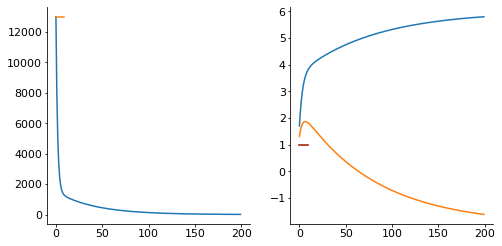

In [146]:
a, b = -2, 6
x = torch.rand(1000)
y = a * x + b
theta = torch.nn.Parameter(torch.tensor([1., 1.]))

from torch.optim import SGD

optim = SGD((theta, ), lr=1e-4)

theta0, theta1 = [], []
loss = []
num_epochs = 200
xfit = torch.stack((torch.ones(len(x)), x), 1)
for ii in range(num_epochs):
    optim.zero_grad()
    y_pred = torch.mv(xfit, theta)
    _loss = torch.sum((y_pred - y)**2)
    theta_grad = 2 * torch.matmul(y_pred - y, xfit)
#     theta.grad = 
    _loss.backward()
#     theta.grad = theta_grad
#     print(theta.grad, theta_grad)
    optim.step()
    loss.append(_loss)
    theta0.append(theta.detach()[0].clone())
    theta1.append(theta.detach()[1].clone())
    
fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), ncols=2)
ax1.plot(loss)
ax2.plot(theta0)
ax2.plot(theta1)

theta = torch.nn.Parameter(torch.tensor([1., 1.]))
theta0, theta1 = [], []
loss = []
num_epochs = 10
for ii in range(num_epochs):
    optim.zero_grad()
    y_pred = torch.mv(xfit, theta)
    _loss = torch.sum((y_pred - y)**2)
    theta_grad = 2 * torch.matmul(y_pred - y, xfit)
    print(theta.grad)
    theta.grad = theta_grad
    print(theta.grad, theta_grad)
    optim.step()
    loss.append(_loss)
    theta0.append(theta.detach()[0].clone())
    theta1.append(theta.detach()[1].clone())
    
ax1.plot(loss)
ax2.plot(theta0)
ax2.plot(theta1)

In [134]:
xfit.shape

torch.Size([1000, 2])

In [91]:
torch.mm(xfit, theta)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)